<font size="6"><b>MLP Neural Networks - Part II</b></font>

![Figure_12](img/Figure_12.png)

# Libraries

In [104]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)

import datetime, warnings, scipy
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout , BatchNormalization
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras

# Data Loading

In [2]:
dfm_ready = pd.read_csv('dfm_ready.csv', index_col=0)
dfm_ready.head().append(dfm_ready.tail())

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,99.0,65.0,414.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-5.0,134.0,106.0,846.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.0,190.0,157.0,1120.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,-3.0,206.0,173.0,1222.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7213439,31.0,182.0,142.0,1303.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213440,-1.0,84.0,46.0,331.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213441,-4.0,100.0,72.0,331.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213442,6.0,181.0,148.0,936.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213445,8.0,71.0,44.0,130.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


The next cell will make sure that all my features are in floating format, followed by a double check with the .info() function

In [3]:
df = dfm_ready.astype(float)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4008257 entries, 0 to 7213445
Data columns (total 64 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   DEP_DELAY                      float64
 1   CRS_ELAPSED_TIME               float64
 2   AIR_TIME                       float64
 3   DISTANCE                       float64
 4   FLIGHT_STATUS                  float64
 5   OP_CARRIER_Allegiant Air       float64
 6   OP_CARRIER_American Airlines   float64
 7   OP_CARRIER_Delta Airlines      float64
 8   OP_CARRIER_Endeavor Air        float64
 9   OP_CARRIER_Envoy Air           float64
 10  OP_CARRIER_ExpressJet          float64
 11  OP_CARRIER_Frontier Airlines   float64
 12  OP_CARRIER_Hawaiian Airlines   float64
 13  OP_CARRIER_JetBlue Airways     float64
 14  OP_CARRIER_Mesa Airline        float64
 15  OP_CARRIER_PSA Airlines        float64
 16  OP_CARRIER_Republic Airways    float64
 17  OP_CARRIER_SkyWest Airlines    float64
 18  OP

==================================================================================

# Function Library

This is a quick parenthesis to write down a few functions that I will be using to evaluate every model once finish training it. 

In [117]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('LOSS', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('ACCURACY', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.show()

In [121]:
def conf_matrix(conf_mat):
    
    conf_mat = pd.DataFrame(conf_mat, index = ['0', '1'], columns = ['0', '1'])
    sns.set(font_scale=1.4)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_mat, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()


In [92]:
def model_metrics(a, b):
    
    accuracy = metrics.accuracy_score(a, b)
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)

    print('Accuracy:', round(accuracy*100, 2),'%')
    print('Precision score:', round(precision*100, 2),'%')
    print('Recall score:', round(recall*100, 2),'%')
    print('F1 score:', round(f1*100, 2),'%')

==================================================================================

<b>Target (y) and Features (X) definitions:</b>

The first model of this Notebook will have only the FLIGHT_STATUS (target) dropped from the input data. The reason for this is to be able to compare the accuracy and other metrics with the other models which will have the DEP_DELAY and all the MONTHS dropped as well. The months have been dropped following a feature selection done, which suggested that the months would not affect the model and by looking at the plots on the EDA, this is clear as there are no real trends or patterns with the months

In [6]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS'], axis=1)

# Neural Network Conditions

1. Data has to be purely numerical<br>
2. Data cannot contain missing values<br>
3. Data has to be Normalized<br>

In [146]:
df.isna().sum().sum()

0

We know the data is purely numerical and that it has no missing values, now all is needed is to normalized and we will do it by using the <b>StandardScaler</b>

In [7]:
col_names = list(df.columns)

s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

In [8]:
df_s.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-0.321419,1.534191,1.418987,1.176912,-0.768926,-0.081396,-0.435286,-0.442703,-0.180393,-0.187732,-0.159841,-0.126919,-0.036401,-0.212356,-0.159955,-0.187231,-0.217581,-0.332741,-0.406602,-0.164254,2.847426,-0.058525,-0.326623,-0.193125,-0.244507,-0.337433,-0.269893,4.021508,-0.200975,-0.245629,-0.203773,-0.240557,-0.202074,-0.278545,-0.18927,-0.194314,-0.170627,-0.215048,-0.169988,-0.212396,-0.189515,-0.789294,1.317508,-0.469889,-0.675979,1.355474,-0.666541,-0.279066,-0.301892,-0.301231,-0.306987,-0.308162,-0.31287,-0.313251,-0.298598,-0.307719,-0.297483,-0.298999,-0.409388,-0.411835,-0.417282,-0.418911,-0.371936,-0.405995
1,-0.384744,-0.703566,-0.754700,-0.729017,-0.768926,-0.081396,-0.435286,-0.442703,-0.180393,-0.187732,-0.159841,-0.126919,-0.036401,-0.212356,-0.159955,-0.187231,-0.217581,-0.332741,-0.406602,-0.164254,2.847426,-0.058525,-0.326623,-0.193125,-0.244507,-0.337433,-0.269893,-0.248663,-0.200975,-0.245629,-0.203773,-0.240557,-0.202074,-0.278545,-0.18927,-0.194314,-0.170627,-0.215048,-0.169988,4.708181,-0.189515,1.266955,-0.759008,-0.469889,-0.675979,1.355474,-0.666541,-0.279066,-0.301892,-0.301231,-0.306987,-0.308162,-0.31287,-0.313251,-0.298598,-0.307719,-0.297483,-0.298999,-0.409388,-0.411835,-0.417282,-0.418911,-0.371936,-0.405995


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Modeling

## Model 1

In [110]:
model_1 = Sequential()

model_1.add(Dense(50, activation='relu', input_shape=(63,)))

model_1.add(Dense(30, activation='relu'))

model_1.add(Dense(10, activation='relu'))

model_1.add(Dense(1, activation='sigmoid'))

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_64 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_65 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


In [111]:
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
results1 = model_1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 2705572 samples, validate on 300620 samples
Epoch 1/10
2705572/2705572 [==============================] - 142s 52us/step - loss: 0.3436 - acc: 0.8577 - val_loss: 0.3239 - val_acc: 0.8663
Epoch 2/10
2705572/2705572 [==============================] - 137s 51us/step - loss: 0.3276 - acc: 0.8640 - val_loss: 0.3245 - val_acc: 0.8666
Epoch 3/10
2705572/2705572 [==============================] - 129s 48us/step - loss: 0.3259 - acc: 0.8648 - val_loss: 0.3260 - val_acc: 0.8659
Epoch 4/10
2705572/2705572 [==============================] - 123s 45us/step - loss: 0.3248 - acc: 0.8653 - val_loss: 0.3301 - val_acc: 0.8608
Epoch 5/10
2705572/2705572 [==============================] - 123s 45us/step - loss: 0.3243 - acc: 0.8655 - val_loss: 0.3208 - val_acc: 0.8672
Epoch 6/10
2705572/2705572 [==============================] - 124s 46us/step - loss: 0.3234 - acc: 0.8658 - val_loss: 0.3255 - val_acc: 0.8648
Epoch 7/10
2705572/2705572 [==============================] - 125s 46us/step - loss: 0.32

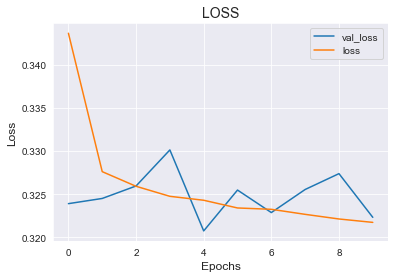

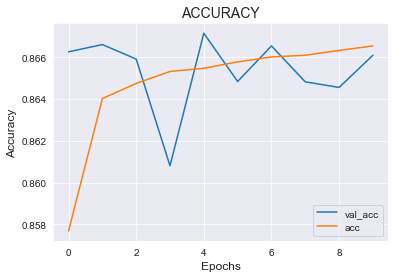

In [118]:
visualize_training_results(results1)

In [128]:
y_pred_m1 = model_1.predict(X_test)
y_pred_m1 =(y_pred_m1 > 0.5)

In [129]:
cm_m1 = confusion_matrix(y_test, y_pred_m1)
print(cm_m1)
print("------------------")
print(classification_report(y_test, y_pred_m1))

[[609344  19891]
 [113924 258906]]
------------------
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90    629235
         1.0       0.93      0.69      0.79    372830

    accuracy                           0.87   1002065
   macro avg       0.89      0.83      0.85   1002065
weighted avg       0.87      0.87      0.86   1002065



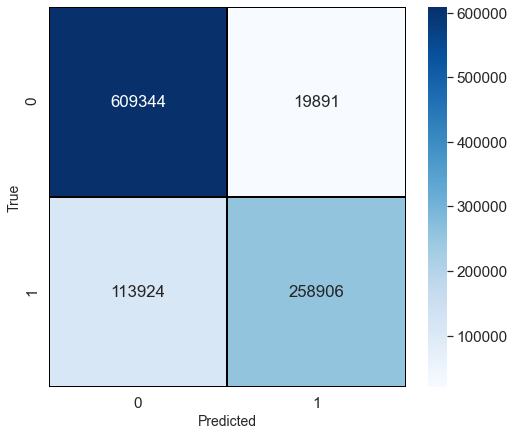

In [131]:
conf_matrix(cm_m1)

In [130]:
model_metrics(y_test, y_pred_m1)

Accuracy: 86.65 %
Precision score: 92.87 %
Recall score: 69.44 %
F1 score: 79.46 %


=========================================================================================

<b>FROM HERE ONWARDS THE MODELS HAVE A DIFFERENT SET OF FEATURES WITH ALL THE MONTHS BEING DROPPED. AFTER DOING A FEATURE SELECTION IT WAS CLEAR THAT THESE WOULD NOT HAVE ANY RELEVENCA IN THE MODEEL AND THEREFORE WOULD CAUSE NOISE. 

=========================================================================================

In [37]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS', 'DEP_DELAY', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'], axis=1)

## Model 2

In [42]:
model_2 = Sequential()

model_2.add(Dense(50, activation='relu', input_shape=(63,)))

model_2.add(Dense(30, activation='relu'))

model_2.add(Dense(10, activation='relu'))

model_2.add(Dense(1, activation='sigmoid'))

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_29 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_30 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


In [43]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
results2 = model_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 2705572 samples, validate on 300620 samples
Epoch 1/10
2705572/2705572 [==============================] - 191s 71us/step - loss: 0.3396 - acc: 0.8589 - val_loss: 0.3267 - val_acc: 0.8650
Epoch 2/10
2705572/2705572 [==============================] - 186s 69us/step - loss: 0.3270 - acc: 0.8643 - val_loss: 0.3243 - val_acc: 0.8657
Epoch 3/10
2705572/2705572 [==============================] - 185s 68us/step - loss: 0.3254 - acc: 0.8647 - val_loss: 0.3528 - val_acc: 0.8492
Epoch 4/10
2705572/2705572 [==============================] - 188s 70us/step - loss: 0.3249 - acc: 0.8650 - val_loss: 0.3242 - val_acc: 0.8656
Epoch 5/10
2705572/2705572 [==============================] - 185s 68us/step - loss: 0.3239 - acc: 0.8655 - val_loss: 0.3232 - val_acc: 0.8656
Epoch 6/10
2705572/2705572 [==============================] - 186s 69us/step - loss: 0.3235 - acc: 0.8656 - val_loss: 0.3213 - val_acc: 0.8668
Epoch 7/10
2705572/2705572 [==============================] - 183s 68us/step - loss: 0.32

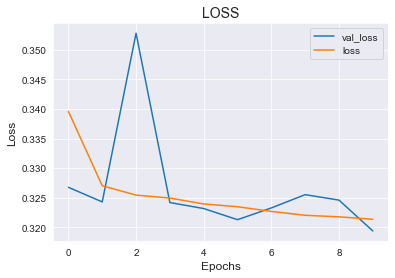

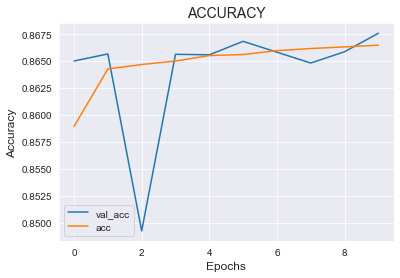

In [119]:
visualize_training_results(results2)

In [125]:
y_pred_m2 = model_2.predict(X_test)
y_pred_m2 =(y_pred_m2 > 0.5)

In [126]:
cm_m2 = confusion_matrix(y_test, y_pred_m2)
print(cm_m2)
print("------------------")
print(classification_report(y_test, y_pred_m2))

[[597824  31411]
 [101152 271678]]
------------------
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90    629235
         1.0       0.90      0.73      0.80    372830

    accuracy                           0.87   1002065
   macro avg       0.88      0.84      0.85   1002065
weighted avg       0.87      0.87      0.86   1002065



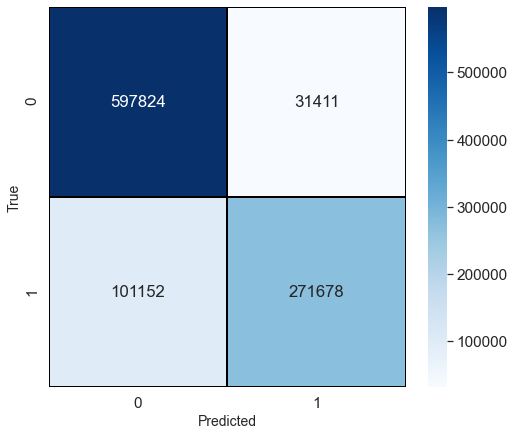

In [127]:
conf_matrix(cm_m2)

In [133]:
model_metrics(y_test, y_pred_m2)

Accuracy: 86.77 %
Precision score: 89.64 %
Recall score: 72.87 %
F1 score: 80.39 %


=========================================================================================

=========================================================================================

## Model 3

In [49]:
model_3 = Sequential()

model_3.add(Dense(50, activation='relu', input_shape=(63,)))

model_3.add(Dense(30, activation='relu'))

model_3.add(Dense(15, activation='relu'))

model_3.add(Dense(5, activation='relu'))

model_3.add(Dense(1, activation='sigmoid'))

model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_38 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_39 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 6         
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
results3 = model_3.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 2705572 samples, validate on 300620 samples
Epoch 1/2
2705572/2705572 [==============================] - 164s 60us/step - loss: 0.3393 - acc: 0.8590 - val_loss: 0.3230 - val_acc: 0.8663
Epoch 2/2
2705572/2705572 [==============================] - 124s 46us/step - loss: 0.3271 - acc: 0.8640 - val_loss: 0.3236 - val_acc: 0.8662


In [139]:
y_pred_m3 = model_3.predict(X_test)
y_pred_m3 =(y_pred>0.5)

In [140]:
cm_m3 = confusion_matrix(y_test, y_pred_m3)
print(cm_m3)
print("------------------")
print(classification_report(y_test, y_pred_m3))

[[612248  16987]
 [138749 234081]]
------------------
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89    629235
         1.0       0.93      0.63      0.75    372830

    accuracy                           0.84   1002065
   macro avg       0.87      0.80      0.82   1002065
weighted avg       0.86      0.84      0.84   1002065



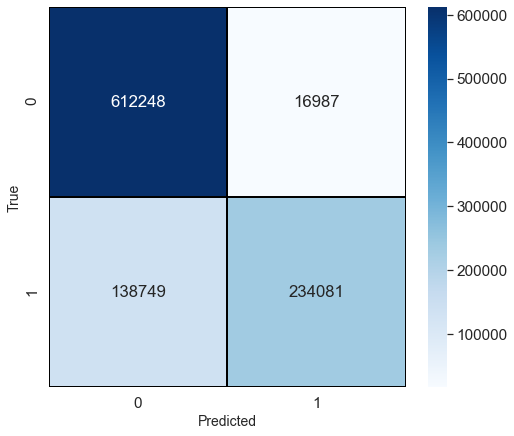

In [141]:
conf_matrix(cm_m3)

In [142]:
model_metrics(y_test, y_pred_m3)

Accuracy: 84.46 %
Precision score: 93.23 %
Recall score: 62.78 %
F1 score: 75.04 %


=========================================================================================

=========================================================================================

## Model 4

In [52]:
model_4 = Sequential()

model_4.add(Dense(50, activation='tanh', input_shape=(63,)))

model_4.add(Dense(30, activation='tanh'))

model_4.add(Dense(15, activation='tanh'))

model_4.add(Dense(5, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))

model_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_43 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_44 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 6         
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [53]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
results4 = model_4.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 2705572 samples, validate on 300620 samples
Epoch 1/2
2705572/2705572 [==============================] - 128s 47us/step - loss: 0.3620 - acc: 0.8525 - val_loss: 0.3394 - val_acc: 0.8642
Epoch 2/2
2705572/2705572 [==============================] - 158s 58us/step - loss: 0.3506 - acc: 0.8569 - val_loss: 0.3372 - val_acc: 0.8647


In [135]:
y_pred_m4 = model_4.predict(X_test)
y_pred_m4 =(y_pred>0.5)

In [136]:
cm_m4 = confusion_matrix(y_test, y_pred_m4)
print(cm_m4)
print("------------------")
print(classification_report(y_test, y_pred_m4))

[[612248  16987]
 [138749 234081]]
------------------
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89    629235
         1.0       0.93      0.63      0.75    372830

    accuracy                           0.84   1002065
   macro avg       0.87      0.80      0.82   1002065
weighted avg       0.86      0.84      0.84   1002065



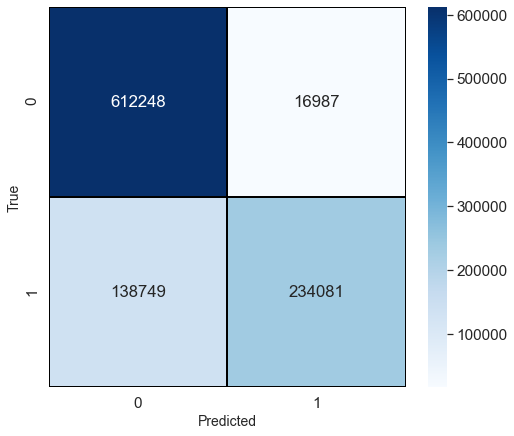

In [137]:
conf_matrix(cm_m4)

In [138]:
model_metrics(y_test, y_pred_m4)

Accuracy: 84.46 %
Precision score: 93.23 %
Recall score: 62.78 %
F1 score: 75.04 %


=========================================================================================

=========================================================================================

## Model 5

In [55]:
model_5 = Sequential()

model_5.add(Dense(50, activation='tanh', input_shape=(63,)))

model_5.add(Dense(30, activation='tanh'))

model_5.add(Dense(15, activation='tanh'))

model_5.add(Dense(5, activation='relu'))

model_5.add(Dense(1, activation='sigmoid'))

model_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_48 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_49 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 6         
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
results5 = model_5.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.1)

Train on 2705572 samples, validate on 300620 samples
Epoch 1/25
2705572/2705572 [==============================] - 153s 57us/step - loss: 0.3594 - acc: 0.8541 - val_loss: 0.3801 - val_acc: 0.8425
Epoch 2/25
2705572/2705572 [==============================] - 147s 54us/step - loss: 0.3503 - acc: 0.8574 - val_loss: 0.3385 - val_acc: 0.8652
Epoch 3/25
2705572/2705572 [==============================] - 146s 54us/step - loss: 0.3485 - acc: 0.8576 - val_loss: 0.3369 - val_acc: 0.8627
Epoch 4/25
2705572/2705572 [==============================] - 146s 54us/step - loss: 0.3470 - acc: 0.8577 - val_loss: 0.3502 - val_acc: 0.8558
Epoch 5/25
2705572/2705572 [==============================] - 2094s 774us/step - loss: 0.3465 - acc: 0.8578 - val_loss: 0.3577 - val_acc: 0.8447
Epoch 6/25
2705572/2705572 [==============================] - 416s 154us/step - loss: 0.3463 - acc: 0.8576 - val_loss: 0.3378 - val_acc: 0.8643
Epoch 7/25
2705572/2705572 [==============================] - 422s 156us/step - loss: 

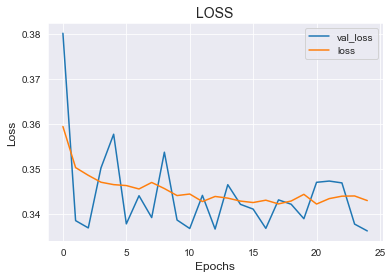

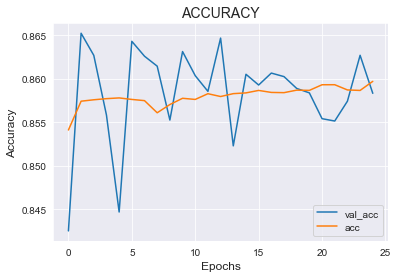

In [120]:
visualize_training_results(results5)

In [93]:
y_pred_m5 = model_5.predict(X_test)
y_pred_m5 =(y_pred_m5 > 0.5)

In [94]:
cm_m5 = confusion_matrix(y_test, y_pred_m5)
print(cm_m5)
print("------------------")
print(classification_report(y_test, y_pred_m5))

[[579238  49997]
 [ 91701 281129]]
------------------
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89    629235
         1.0       0.85      0.75      0.80    372830

    accuracy                           0.86   1002065
   macro avg       0.86      0.84      0.84   1002065
weighted avg       0.86      0.86      0.86   1002065



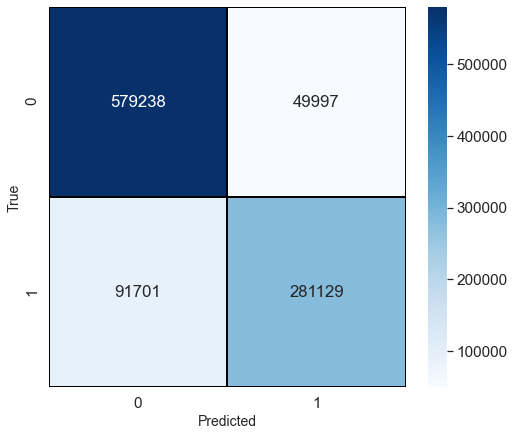

In [123]:
conf_matrix(cm_m5)

In [97]:
model_metrics(y_test, y_pred_m5)

Accuracy: 85.86 %
Precision score: 84.9 %
Recall score: 75.4 %
F1 score: 79.87 %


=========================================================================================

=========================================================================================

## Model 6

In [62]:
model_6 = Sequential()

model_6.add(Dense(50, activation='tanh', input_shape=(63,)))

model_6.add(Dense(40, activation='relu'))

model_6.add(Dense(30, activation='tanh'))

model_6.add(Dense(10, activation='relu'))

model_6.add(Dense(5, activation='relu'))

model_6.add(Dense(1, activation='sigmoid'))

model_6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_58 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_59 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_60 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_61 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 6         
Total params: 6,841
Trainable params: 6,841
Non-trainable params: 0
_________________________________________________________________


In [63]:
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
results6 = model_6.fit(X_train, y_train, epochs=2, batch_size=10, validation_split=0.1)

Train on 2705572 samples, validate on 300620 samples
Epoch 1/2
2705572/2705572 [==============================] - 535s 198us/step - loss: 0.3817 - acc: 0.8427 - val_loss: 0.3954 - val_acc: 0.8402
Epoch 2/2
2705572/2705572 [==============================] - 470s 174us/step - loss: 0.3667 - acc: 0.8474 - val_loss: 0.3668 - val_acc: 0.8445


No need for the visualizations because of the low epoch number. This was just a parameters test.

In [69]:
eval_model = model_6.evaluate(X_train, y_train)
eval_model

3006192/3006192 [==============================] - 68s 23us/step


[0.36567949176902476, 0.8445408676491721]

In [106]:
y_pred_m6 = model_6.predict(X_test)
y_pred_m6 =(y_pred>0.5)

In [107]:
cm_m6 = confusion_matrix(y_test, y_pred_m6)
print(cm_m6)
print("------------------")
print(classification_report(y_test, y_pred_m6))

[[612248  16987]
 [138749 234081]]
------------------
              precision    recall  f1-score   support

         0.0       0.82      0.97      0.89    629235
         1.0       0.93      0.63      0.75    372830

    accuracy                           0.84   1002065
   macro avg       0.87      0.80      0.82   1002065
weighted avg       0.86      0.84      0.84   1002065



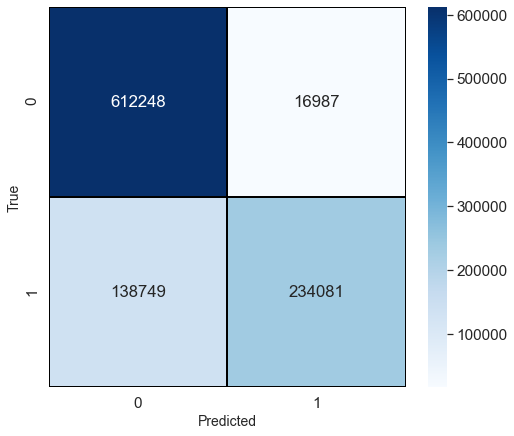

In [122]:
conf_matrix(cm_m6)

In [91]:
model_metrics(y_test, y_pred)

Accuracy: 84.46 %
Precision score: 93.23 %
Recall score: 62.78 %
F1 score: 75.04 %


## Model 7

In [150]:
model_7 = Sequential()

model_7.add(Dense(50, activation='tanh', input_shape=(63,)))

model_7.add(Dense(30, activation='tanh'))

model_7.add(Dense(15, activation='tanh'))

model_7.add(Dense(5, activation='relu'))

model_7.add(Dense(1, activation='sigmoid'))

model_7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 50)                3200      
_________________________________________________________________
dense_73 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_74 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_75 (Dense)             (None, 5)                 80        
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 6         
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [151]:
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])